# Predict geothermal heat flux: KNN regression with Continent Level Cross Validation

References:
* http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://github.com/amirkdv/ghf-greenland-gbrt

Install mlxtend to use SequentialFeatureSelector (pip install mlxtend).

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
from joblib import dump, load
from project import plt_ant_feat

In [2]:
def find_continent(df):
    cont = []
    for r in df.itertuples():
        if (r.lat > 0)  & (r.lon < -25): # NA
            cont.append(0)
        elif (r.lat > 30)  & (75 > r.lon) & (r.lon > -25): #EU
            cont.append(1)
        else:
            cont.append(2)
    return cont

Load the data.

In [3]:
X_labels = ["thickness_upper_crust",
            "thickness_middle_crust",
            "upper_mantle_density_anomaly",
            "d_2_ridge",
            "d_2_trench",
            "d_2_trans_ridge",
            "d_2_volcano",
            "d_2_hotspot",
            "thickness_crust",
            "d_2_young_rift",
#             "lon",
#             "lat".
#             "GHF",
            "upper_mantle_vel_structure",
            "age",
            "magnetic_anomaly",
            "depth_to_moho",
            "lithos_asthenos_bdry",
            "bougeur_gravity_anomaly",
            "topography"
]

y_lable = 'GHF'

scaler = preprocessing.MinMaxScaler()

n_scale_labels = ['lat', 'lon', 'GHF']

# Load data
data_train = pd.read_csv('data/R17_global_train.csv')
train_llg = data_train[n_scale_labels]
data_train = data_train.drop(columns=n_scale_labels)
data_train[:] = scaler.fit_transform(data_train)
data_train[n_scale_labels] = train_llg
data_train['continent'] = find_continent(data_train)
train = data_train

data_test = pd.read_csv('data/R17_global_test.csv')
test_llg = data_test[n_scale_labels]
data_test = data_test.drop(columns=n_scale_labels)
data_test[:] = scaler.transform(data_test)
data_test[n_scale_labels] = test_llg
data_test['continent'] = find_continent(data_test)
test = data_test



print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (3227, 21)
test shape: (807, 21)


In [18]:
dump(scaler, 'models/knn_scaler.joblib')

['knn_scaler.joblib']

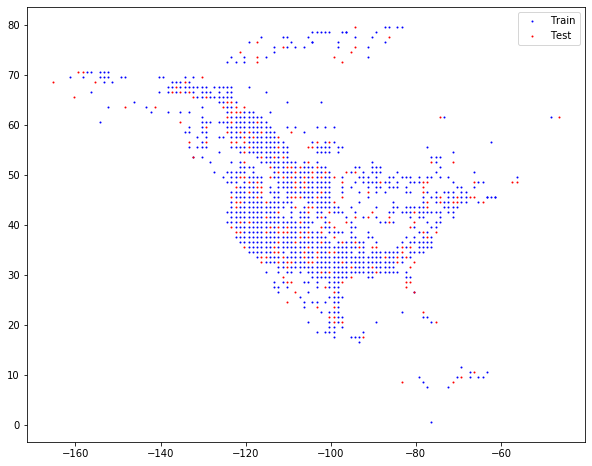

In [4]:
na_train = train[train['continent'] == 0]
na_test = test[test['continent'] == 0]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(na_train['lon'], na_train['lat'], s=1, c='b', label='Train')
ax.scatter(na_test['lon'], na_test['lat'], s=1, c='r', label='Test')
ax.legend()
plt.show()

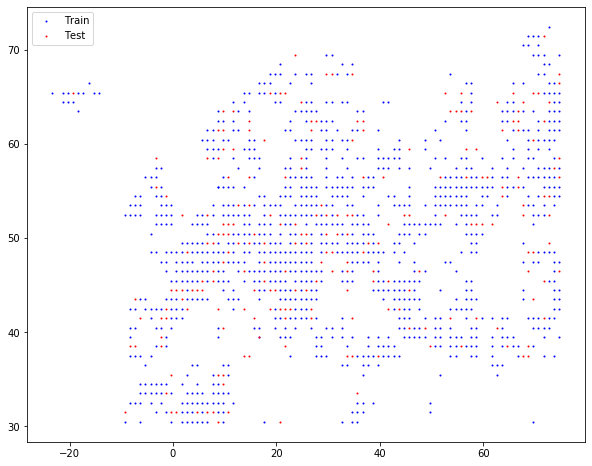

In [5]:
eu_train = train[train['continent'] == 1]
eu_test = test[test['continent'] == 1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(eu_train['lon'], eu_train['lat'], s=1, c='b', label='Train')
ax.scatter(eu_test['lon'], eu_test['lat'], s=1, c='r', label='Test')
ax.legend()
plt.show()

In [6]:
eu_na_train = train[train['continent'] <= 1]
eu_na_test = test[test['continent'] <= 1]

X_eu_na_train = eu_na_train[X_labels]
y_eu_na_train = eu_na_train[y_lable]

X_eu_na_test = eu_na_test[X_labels]
y_eu_na_test = eu_na_test[y_lable]

In [9]:
research = False

if research:
    gkf = GroupKFold(n_splits=2)
    param_grid = {'n_neighbors': range(20, 60),
       'weights': ['uniform', 'distance'],
       'metric': ['euclidean', 'manhattan', 'chebyshev']}

    poss_params = ParameterGrid(param_grid)

    def find_sfs(params):
        knn = KNeighborsRegressor(n_neighbors=params['n_neighbors'], metric=params['metric'], weights=params['weights'])

        sfs = SFS(estimator=knn, 
                   k_features='best',
                   forward=False, 
                   floating=True,
                   cv=gkf)

        sfs.fit(X_eu_na_train, y_eu_na_train, groups=list(eu_na_train['continent']))

        return sfs

    best_score = None
    best_sfs = None

    for params in tqdm(poss_params):
        sfs = find_sfs(params)

        if best_score is None or sfs.k_score_ > best_score:
            best_score = sfs.k_score_
            best_sfs = sfs
else:
    best_sfs = load('best_sfs.joblib')

In [10]:
print(best_sfs)
print(best_sfs.k_feature_names_)
print(best_sfs.k_score_)

SequentialFeatureSelector(clone_estimator=True, cv=GroupKFold(n_splits=2),
                          estimator=KNeighborsRegressor(algorithm='auto',
                                                        leaf_size=30,
                                                        metric='manhattan',
                                                        metric_params=None,
                                                        n_jobs=None,
                                                        n_neighbors=45, p=2,
                                                        weights='uniform'),
                          floating=True, forward=False, k_features='best',
                          n_jobs=1, pre_dispatch='2*n_jobs', scoring=None,
                          verbose=0)
('thickness_upper_crust', 'upper_mantle_density_anomaly', 'd_2_trench', 'd_2_trans_ridge', 'd_2_volcano', 'd_2_hotspot', 'thickness_crust', 'magnetic_anomaly')
0.46008617484038045


Fit a KNN model using the best hyperparameter values.

In [11]:
best_features = best_sfs.k_feature_names_
X_eu_na_train[list(best_features)]

,thickness_upper_crust,upper_mantle_density_anomaly,d_2_trench,d_2_trans_ridge,d_2_volcano,d_2_hotspot,thickness_crust,magnetic_anomaly
0,0.704457,0.665041,0.214667,0.391622,0.299071,0.165398,0.451038,0.715267
2,0.531938,0.660705,0.051730,0.054583,0.175289,0.151582,0.489316,0.728896
3,0.408865,0.666125,0.293485,0.337368,0.810625,0.209069,0.428132,0.726109
4,0.654913,0.640108,0.493060,0.505118,0.506434,0.209691,0.471022,0.726265
5,0.704260,0.714905,0.485799,0.538254,0.696557,0.242099,0.534973,0.756224
...,...,...,...,...,...,...,...,...
3221,0.704408,0.591870,0.314686,0.323732,0.390948,0.079264,0.420446,0.733129
3222,0.408717,0.431978,0.397083,0.396337,0.456440,0.103720,0.353113,0.716369
3223,0.261019,0.695935,0.266979,0.305238,0.408531,0.119546,0.449347,0.713808
3225,0.679685,0.642818,0.308573,0.423534,0.477677,0.156591,0.437663,0.761759


In [12]:
resave = False
if resave: dump(best_sfs, 'model/best_sfs_scale.joblib')

In [13]:
# Create subsets of train/test data using best features from SFS
knn = best_sfs.estimator
best_features = best_sfs.k_feature_names_
X_train_selected = X_eu_na_train[list(best_features)]
X_test_selected = X_eu_na_test[list(best_features)]

print(knn)
knn.fit(X_train_selected, y_eu_na_train)
print('R^2:', knn.score(X_test_selected, y_eu_na_test))
pred = knn.predict(X_test_selected)
rmse = (1 / np.average(y_eu_na_test)) * math.sqrt(np.average((y_eu_na_test - pred)**2))
print ('RMSE:', rmse)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=45, p=2,
                    weights='uniform')
R^2: 0.595400146997452
RMSE: 0.18636822414165782


In [18]:
ant_data = pd.read_csv('data/ant_features.csv')
ant_data = ant_data.drop(columns=['lat', 'lon'])
ant_data[:] = scaler.transform(ant_data)
X_ant = ant_data[list(best_features)]

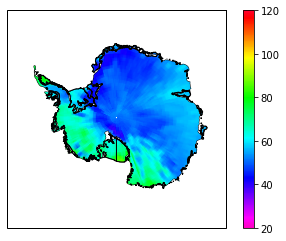

In [19]:
pred_ant = knn.predict(X_ant)
plt_ant_feat(pred_ant)